In [176]:
# Little Jupyter notebook to explore time series data from in situ stations and satellite observations,
# both already in csv format.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/appears_extraction')
all_data_mcd = pd.read_csv('greenland-stations-MCD43A3-006-results.csv', index_col=0)

os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/tower_data/orig_data/')
stn_df = pd.read_csv('NASA-U_03c.dat_Req2003')

# Column variables for readability
date = 'Date'
mcd43a3_sw_wsa = 'MCD43A3_006_Albedo_WSA_shortwave'
mcd43a3_sw_qa = 'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave'

# Specify whether to keep QA == 1, i.e. magnitude inversions

all_qa = True

In [177]:
# Subset and mask station data
 #.loc['alb']
#print(stn_df.columns)

# Filter out non-noon observations from dataset
#TODO Can't figure out why these two filters cannot be combined into single line
filter = stn_df['dec_day'] % 0.5 == 0
stn_df.where(filter, inplace = True)

filter = stn_df['dec_day'] % 1.0 != 0
stn_df.where(filter, inplace = True)

# Remove observations filtered out above
stn_df = stn_df.dropna()

# Clean up dec_days and combine with year to make new date field in yyyy-mm-dd, use as index
stn_df['dec_day'] = stn_df['dec_day'].apply(np.floor)
stn_df['dec_day'] = stn_df['dec_day'].astype(int).astype(str)
stn_df['dec_day'] = stn_df['dec_day'].str.zfill(3)
stn_df['date'] = stn_df['year'].astype(int).astype(str) + stn_df['dec_day']
stn_df['date'] = pd.to_datetime(stn_df['date'], format='%Y%j')
stn_df = stn_df.set_index(stn_df['date'])

# Delete now unnecessary dateparts
del stn_df['year']
del stn_df['dec_day']

# Set albedo fill values to NaN
stn_df['alb'].mask(stn_df['alb'] == 999, np.NaN, inplace=True)

print(stn_df)

            sw_down   sw_up  net_rad   alb       date
date                                                 
2015-01-01      0.0    0.00   -12.16  0.85 2015-01-01
2015-01-02      0.0    0.00   -10.72  0.85 2015-01-02
2015-01-03      0.0    0.00    -6.08  0.85 2015-01-03
2015-01-04      0.0    0.00    -8.08  0.85 2015-01-04
2015-01-05      0.0    0.00    -2.48  0.85 2015-01-05
...             ...     ...      ...   ...        ...
2018-05-18    999.0  170.01   999.00   NaN 2018-05-18
2018-05-19    999.0  153.69   999.00   NaN 2018-05-19
2018-05-20    999.0  175.70   999.00   NaN 2018-05-20
2018-05-21    999.0  173.32   999.00   NaN 2018-05-21
2018-05-22   1028.8  178.36    24.56  0.17 2018-05-22

[1238 rows x 5 columns]


In [178]:
# Subset and mask mcd43 data
mcd_df = all_data_mcd.loc['NASA-U', [date, mcd43a3_sw_wsa, mcd43a3_sw_qa]]

# Mask out fill values
mcd_df[mcd43a3_sw_wsa].mask(mcd_df[mcd43a3_sw_qa] == 255, np.NaN, inplace=True)

# If specified, remove QA == 1
if all_qa:
    mcd_df[mcd43a3_sw_wsa].mask(mcd_df[mcd43a3_sw_qa] == 1, np.NaN, inplace=True)

print(mcd_df)

                Date  MCD43A3_006_Albedo_WSA_shortwave  \
Category                                                 
NASA-U    2000-02-24                               NaN   
NASA-U    2000-02-25                               NaN   
NASA-U    2000-02-26                               NaN   
NASA-U    2000-02-27                               NaN   
NASA-U    2000-02-28                               NaN   
...              ...                               ...   
NASA-U    2020-04-28                             0.835   
NASA-U    2020-04-29                             0.826   
NASA-U    2020-04-30                             0.823   
NASA-U    2020-05-01                             0.820   
NASA-U    2020-05-02                             0.820   

          MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave  
Category                                                            
NASA-U                                                255.0         
NASA-U                                

       MCD43A3_006_Albedo_WSA_shortwave          alb
count                       2779.000000  1087.000000
mean                           0.814666     0.531196
std                            0.014608     0.244207
min                            0.718000     0.170000
25%                            0.807000     0.320000
50%                            0.817000     0.330000
75%                            0.824000     0.790000
max                            0.860000     0.940000


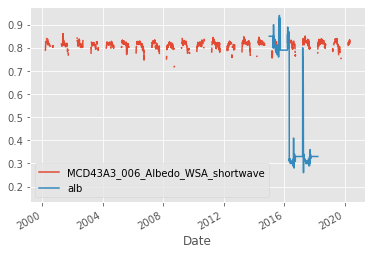

In [179]:
# Plot data
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use("ggplot")

mcd_df[date] = pd.to_datetime(mcd_df[date], yearfirst=True)
mcd_df = mcd_df.set_index(mcd_df[date])
#del mcd_df[date]

# Join satellite observations to stn data based on date
joined_df = mcd_df.join(stn_df, lsuffix='_mcd', rsuffix='_stn')

del joined_df['date']
del joined_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']
del joined_df['sw_down']
del joined_df['sw_up']
del joined_df['net_rad']
del joined_df['Date']

print(joined_df.describe())

joined_df.plot()
